In [364]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [366]:
def load_dir_reduced_to_zfeedback(dirname,file_prefix,max_files):
    '''
    
    '''   
    ## Load all filenames in directory
    var_list = []
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))        
    step_size = 100
    for j in tqdm(np.arange(0,max_files,step_size)):
        BDFs = [BDF.BeadDataFile(dirname+filename) for filename in files[j:j+step_size]]
        [var_list.append(np.mean(BDFs[k].feedback[2])) for k in range(len(BDFs))]
    return var_list


In [367]:
def threshold_max(image,threshold):
    image_to_t = image.transpose()[600:800]
    ret,thresh = cv2.threshold(image_to_t,threshold,255,0)
    return np.argmax(np.mean(thresh,axis=0))


def center_of_mass(image,threshold):
    ret,thresh = cv2.threshold(image,threshold,255,0)
    M = cv2.moments(thresh)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])  
    return cX,cY

In [368]:
def gaussian(x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+params[3]


In [369]:
def gaussian_bead_pos_fit(img,axis=0,low_x_lim=630,up_x_lim=700,low_y_lim=420,up_y_lim=550,upper_area=3000,up_lim_width=20):

    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevalue, ndf)

    def gaussian(x,params=list):
        norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
        return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+params[3]

    
    def chisquare_gaussian(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
   

    area=0
    mean=0
    sigma=0
    constant=0
    
    if(axis==0):
        img2 = img.transpose()
        data_x = range(1024) # give x data
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y)+1 # give y uncertainty
        low_lim_mean = low_y_lim
        up_lim_mean = up_y_lim
        
    if(axis==1):
        data_x = range(1280) # give x data
        data_y = np.mean(img[low_y_lim:up_y_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y)+1 # give y uncertainty
        low_lim_mean = low_x_lim
        up_lim_mean = up_x_lim
        
        
    m=Minuit(chisquare_gaussian, 
             area = 100, # set start parameter
             error_area = 1,
             limit_area= (0,upper_area), # if you want to limit things
             #fix_area = "True", # you can also fix it
             mean = np.argmax(data_y),
             error_mean = 1,
             #fix_mean = "False",
             limit_mean = (low_lim_mean,up_lim_mean),
             sigma = 15,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant = 0,
             error_constant = 1,
             #fix_constant=0,
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    return m.values['mean']#,m

In [370]:
def load_img_files(path):
    # read in the data 
    files = glob.glob(path)
    img_files = []
    for i in range(0,len(files)):
        img_files.append(cv2.imread(files[i],0))
    print(files) 
    return img_files

In [372]:
Year = "2020"
Month = "03"
Day = "06"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)
folder_processed = r"/data/new_trap_processed/harmonics_processed/"+ Year + Month + Day + "/Bead"+str(BeadNumber)


In [406]:
def height_analysis_wrapper(dirname,file_prefix):

    maximum_intensity, mean_intensity, sum_intensity, max_bin_2d, max_bin_1d, max_y_1d_zoom,max_z_1d_zoom = ([] for i in range(7))

    pos_y = [] 
    pos_z =[]
    pos_z_alt =[]
    CoM =[]
    t_m = []
    marginalized=[]
    s = time.time()
    
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.npy')]

    for j in tqdm(range(len(files))):
        try:
            img = np.load(dirname + file_prefix +"%d.npy" %j)
            #img = np.load("/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures/Shaking%d.npy" %j)
            maximum_intensity.append(np.max(img))
            mean_intensity.append(np.mean(img))
            sum_intensity.append(np.sum(img))
            max_bin_2d.append(np.argmax(img))
            max_bin_1d.append(np.argmax(np.mean(img, axis=1)))    
            img2 = img.transpose()
            max_y_1d_zoom.append(np.argmax(np.mean(img[400:500],axis=0)))    
            max_z_1d_zoom.append(np.argmax(np.mean(img2[600:700],axis=0)))    
            pos_z.append(gaussian_bead_pos_fit(img,axis=0))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))
            pos_y.append(gaussian_bead_pos_fit(img,axis=1))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    
            pos_z_alt.append(gaussian_bead_pos_fit(img,axis=0,up_lim_width=7))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    
            CoM.append(center_of_mass(img,np.max(img)/2))
            t_m.append(threshold_max(img,np.max(img)/2))
            #t_m.append(gaussian_bead_pos_fit(thresh,upper_area=50000,up_lim_width=2))
            #pos.append(gaussian_bead_pos_fit(img2))
            #m1 = 
        except:print("Nope")
    e = time.time()
    print("Time passed %d" %(e-s))
    H = t_m,CoM,pos_z,pos_y,pos_z_alt,maximum_intensity, mean_intensity, sum_intensity, max_bin_2d, max_bin_1d, max_y_1d_zoom,max_z_1d_zoom
    np.save(dirname+file_prefix+"height_wrapped.npy",H)
    return H

In [324]:
dirname = folder_basic + "/BeadStability/Pictures_0/"
H2 = height_analysis_wrapper(dirname,"BeadHeight2_")



  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 1/501 [00:00<01:13,  6.78it/s]

  0%|          | 2/501 [00:00<01:08,  7.33it/s]

  1%|          | 3/501 [00:00<01:10,  7.06it/s]

  1%|          | 4/501 [00:00<01:06,  7.44it/s]

  1%|          | 5/501 [00:00<01:10,  7.05it/s]

  1%|          | 6/501 [00:00<01:07,  7.28it/s]

  1%|▏         | 7/501 [00:00<01:02,  7.85it/s]

  2%|▏         | 8/501 [00:01<01:06,  7.39it/s]

  2%|▏         | 9/501 [00:01<01:05,  7.55it/s]

  2%|▏         | 10/501 [00:01<01:03,  7.75it/s]

  2%|▏         | 11/501 [00:01<01:02,  7.80it/s]

  2%|▏         | 12/501 [00:01<01:02,  7.79it/s]

  3%|▎         | 13/501 [00:01<00:58,  8.28it/s]

  3%|▎         | 14/501 [00:01<00:59,  8.15it/s]

  3%|▎         | 15/501 [00:01<00:57,  8.41it/s]

  3%|▎         | 16/501 [00:02<00:57,  8.41it/s]

  3%|▎         | 17/501 [00:02<00:58,  8.26it/s]

  4%|▎         | 18/501 [00:02<01:00,  8.00it/s]

  4%|▍         | 19/501 [00:02<00:59,  8.13it/s]

  4%|▍         |

 58%|█████▊    | 290/501 [00:35<00:26,  7.96it/s]

 58%|█████▊    | 291/501 [00:35<00:26,  7.78it/s]

 58%|█████▊    | 292/501 [00:36<00:27,  7.59it/s]

 58%|█████▊    | 293/501 [00:36<00:27,  7.63it/s]

 59%|█████▊    | 294/501 [00:36<00:26,  7.76it/s]

 59%|█████▉    | 295/501 [00:36<00:26,  7.86it/s]

 59%|█████▉    | 296/501 [00:36<00:25,  8.00it/s]

 59%|█████▉    | 297/501 [00:36<00:25,  7.89it/s]

 59%|█████▉    | 298/501 [00:36<00:25,  8.00it/s]

 60%|█████▉    | 299/501 [00:36<00:26,  7.70it/s]

 60%|█████▉    | 300/501 [00:37<00:25,  7.92it/s]

 60%|██████    | 301/501 [00:37<00:25,  7.78it/s]

 60%|██████    | 302/501 [00:37<00:25,  7.68it/s]

 60%|██████    | 303/501 [00:37<00:25,  7.74it/s]

 61%|██████    | 304/501 [00:37<00:24,  7.88it/s]

 61%|██████    | 305/501 [00:37<00:24,  8.16it/s]

 61%|██████    | 306/501 [00:37<00:24,  7.83it/s]

 61%|██████▏   | 307/501 [00:37<00:25,  7.71it/s]

 61%|██████▏   | 308/501 [00:38<00:24,  7.75it/s]

 62%|██████▏   | 309/501 [00:38

FileNotFoundError: [Errno 2] No such file or directory: '/data/new_trap/20200303/Bead1/BeadStability/Pictures_0/BeadHeight2_500.npy'

In [77]:
H0 = np.load("/data/new_trap/20200303/Bead1/BeadStability/Pictures_0/BeadHeight_height_wrapped.npy", allow_pickle=True)
H1 = np.load("/data/new_trap/20200303/Bead1/BeadStability/Pictures_0/BeadHeight1_height_wrapped.npy", allow_pickle=True)

In [181]:
image = np.load("/data/new_trap/20200303/Bead1/BeadStability/Pictures_0/BeadHeight_51.npy")
image1 = np.load("/data/new_trap/20200303/Bead1/BeadStability/Pictures_0/BeadHeight1_405.npy")
image2 = np.load("/data/new_trap/20200303/Bead1/BeadStability/Pictures_0/BeadHeight2_325.npy")

In [182]:
np.max(image)

148

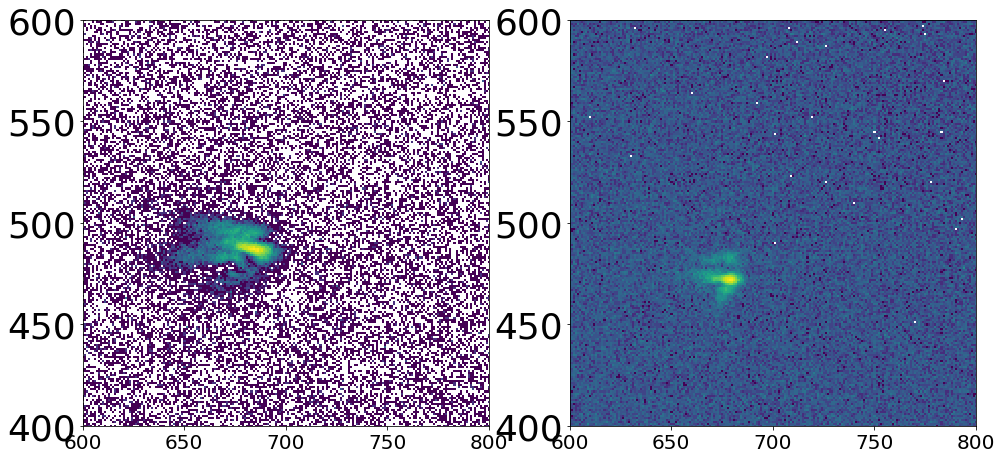

In [183]:
mult_img = []
#[mult_img.append(np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_%d.npy"% i)[400:600]) for i in np.arange(1,16500,4000)]
mult_img.append(image)
mult_img.append(image)
mult_img.append(image2)

fig=plt.figure(figsize=(16, 16))
columns = 2#int(len(mult_img)/2)
rows = 1#int(len(mult_img)/2)
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mult_img[i],norm=LogNorm())
    plt.xlim(600,800)   
    plt.ylim(400,600)
plt.show()

In [319]:
image2 = np.load("/data/new_trap/20200303/Bead1/BeadStability/Pictures_0/BeadHeight2_.npy")
ret,thresh = cv2.threshold(image,np.max(image2)/2,255,0)
m1 = gaussian_bead_pos_fit(thresh,upper_area=50000,up_lim_width=2)


(460, 500)

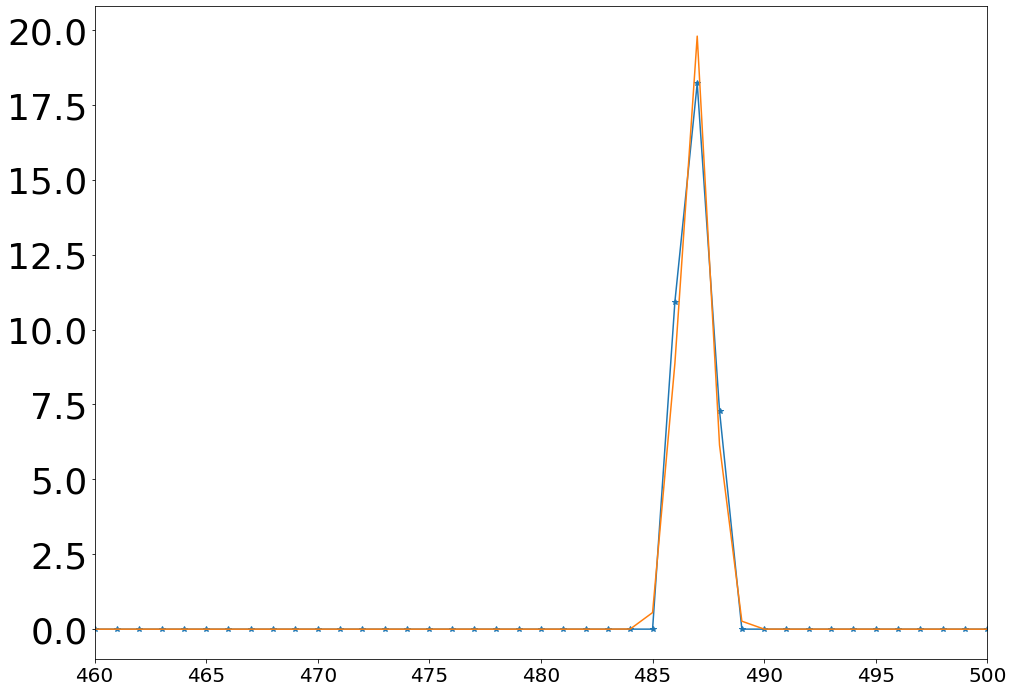

In [320]:
#plt.plot(np.mean(image.transpose()[630:700],axis=0))
plt.plot(np.mean(thresh.transpose()[630:700],axis=0),linestyle="-",marker="*")
plt.plot(gaussian(range(1024),params=[m1[1].values["area"],m1[1].values["mean"],m1[1].values["sigma"],m1[1].values["constant"]]))
plt.xlim(460,500)

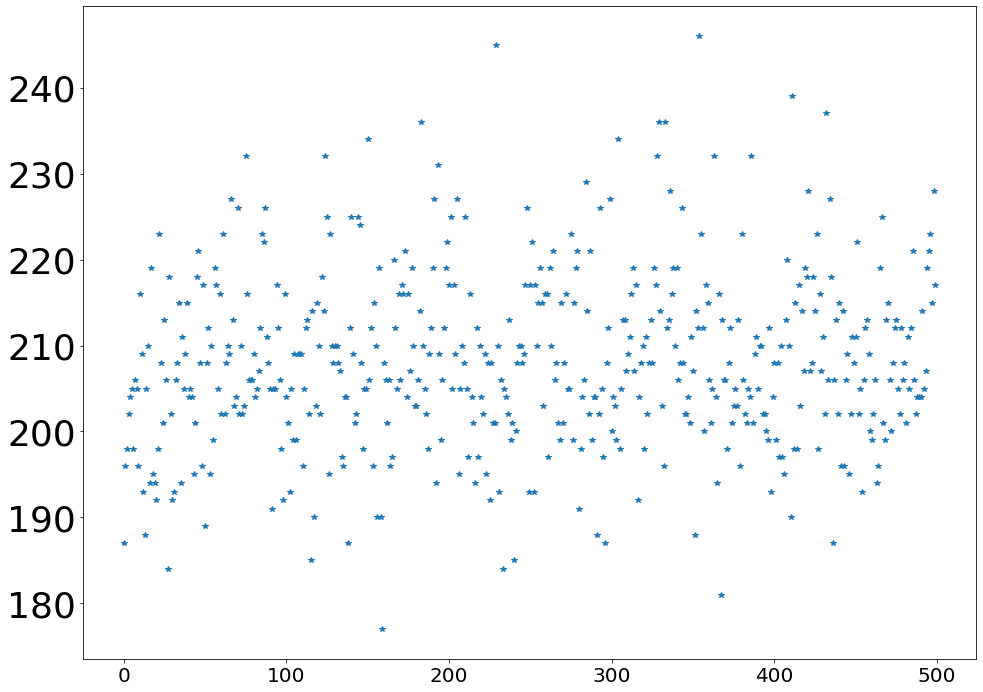

In [214]:
plt.plot(H2[5],linestyle="",marker="*")

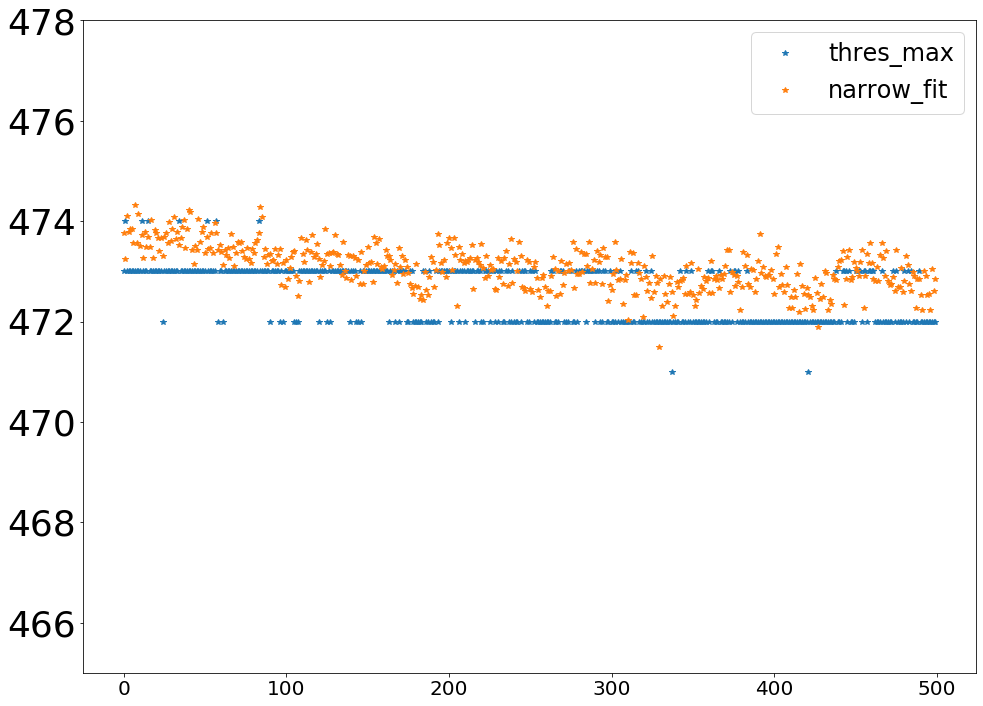

In [328]:
plt.plot(H2[0],label="thres_max",marker="*",linestyle="")
#plt.plot(H2[1],label="CoM",marker="*",linestyle="")
#plt.plot(H2[2],label="fit",marker="*",linestyle="")
plt.plot(H2[4],label="narrow_fit",marker="*",linestyle="")
#plt.plot(H2[-1],label="max_zoom",marker="*",linestyle="")
plt.ylim(465,478)
plt.legend()

plt.show()

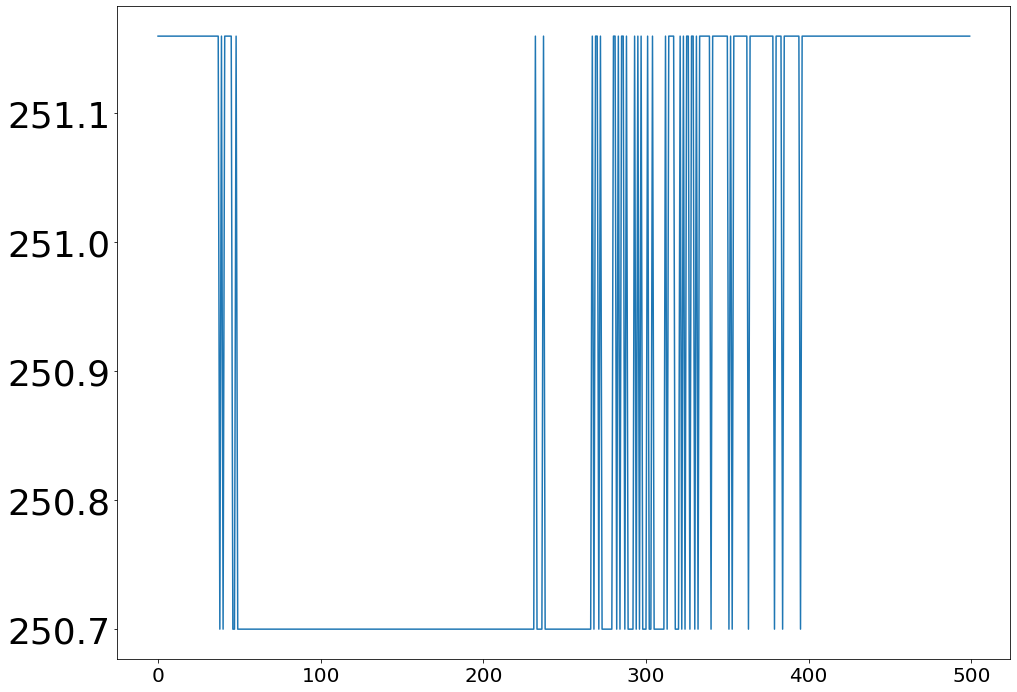

In [330]:
plt.plot(1024*0.46-np.multiply(0.46,H[0]))


(5000, 10000)

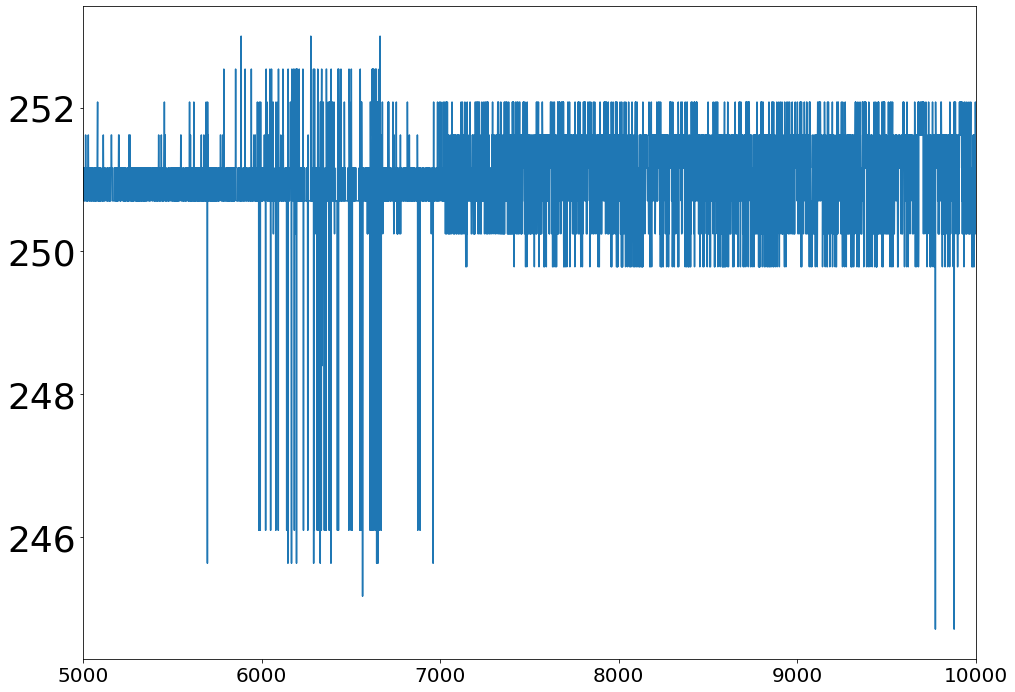

In [27]:
plt.plot(1024*0.46-np.multiply(0.46,H[-1]))
plt.xlim(5000,10000)

In [28]:
img_test = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_11000.npy")
plt.imshow(img_test[400:600],norm=LogNorm())
plt.xlim(600,800)

NameError: name 'LogNorm' is not defined

In [29]:
img_test2 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_7010.npy")
plt.imshow(img_test2[400:600],norm=LogNorm())
plt.xlim(600,800)

NameError: name 'LogNorm' is not defined

In [30]:
plt.imshow(img_test[400:600]+img_test2[400:600],norm=LogNorm())
plt.xlim(600,800)

NameError: name 'LogNorm' is not defined

In [31]:
ret,thresh = cv2.threshold(img_test3,np.max(img_test2)/2,255,0)
M = cv2.moments(thresh)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX*0.46,1024*0.46-cY*0.46)

217.12 434.24


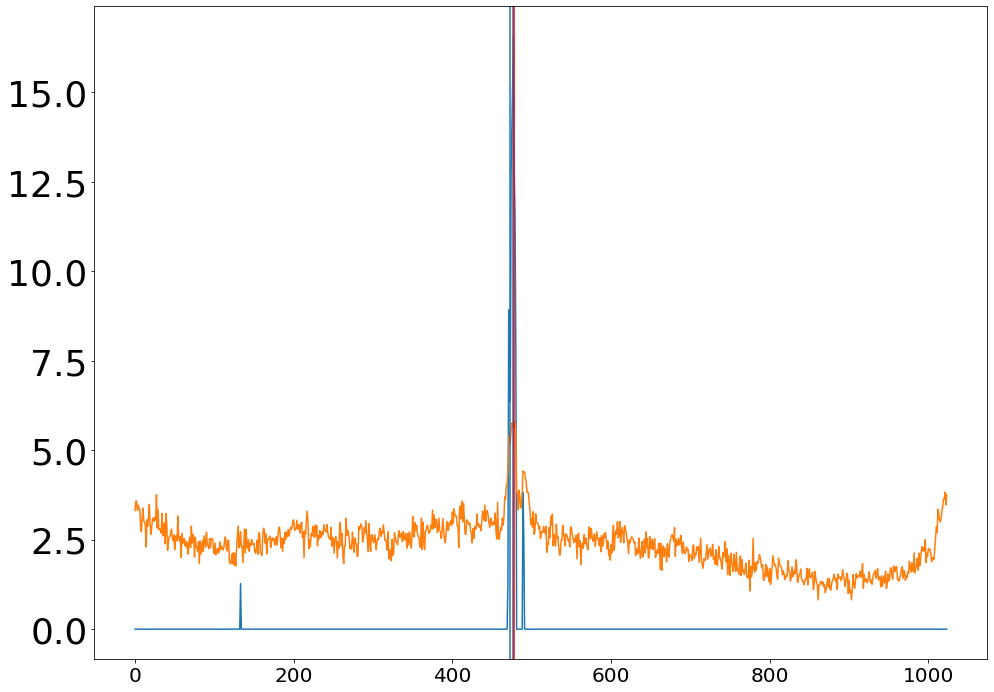

In [32]:
img_test3 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_7010.npy").transpose()[600:800]
plt.plot(np.mean(thresh,axis=0))
plt.plot(np.mean(img_test3,axis=0))
plt.axvline(cX)
plt.axvline(np.argmax(np.mean(thresh,axis=0)))
plt.axvline(np.argmax(np.mean(img_test3,axis=0)),color="red")


#plt.xlim(400,600)

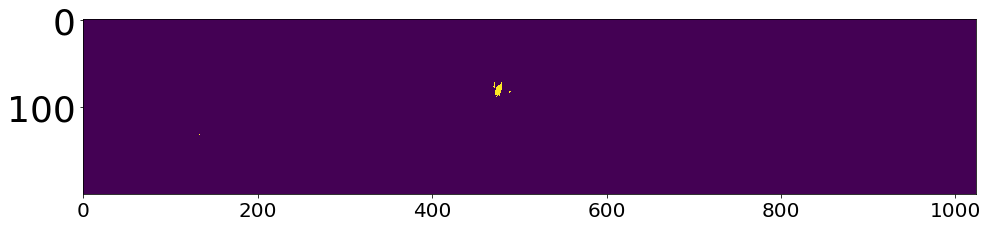

In [33]:
plt.imshow(thresh)

NameError: name 'LogNorm' is not defined

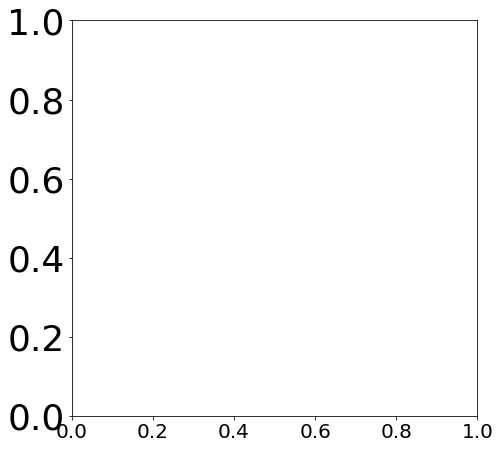

In [35]:

mult_img = []
[mult_img.append(np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_%d.npy"% i)[400:600]) for i in np.arange(1,16500,4000)]

fig=plt.figure(figsize=(16, 16))
columns = int(len(mult_img)/2)
rows = int(len(mult_img)/2)
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mult_img[i],norm=LogNorm())
    plt.xlim(600,800)    
plt.show()

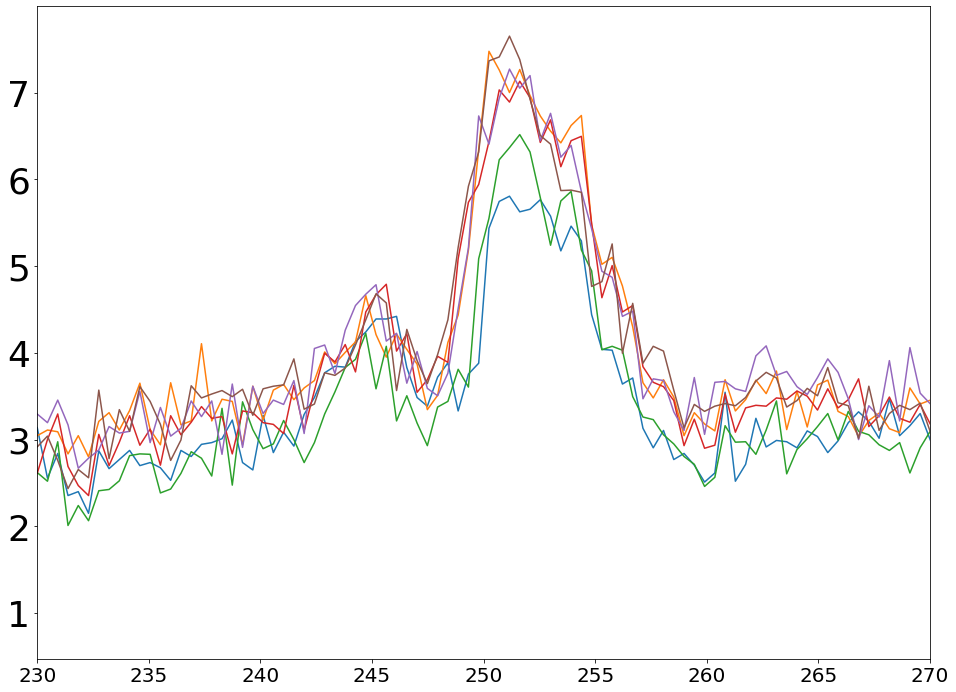

In [362]:
for i in np.arange(7010,7150,25):
    img_test3 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_%d.npy" %i).transpose()
    #img_test4 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_10381.npy").transpose()
    plt.plot(1024*0.46-np.arange(0,1024*0.46,0.46),np.mean(img_test3[600:800],axis=0))
    #plt.plot(np.mean(img_test4[600:800],axis=0))
    plt.xlim(230,270)
plt.savefig("Results/Height_feedback_issues_exampl_for_bad_bead.png", dpi=300, bbox_inches="tight")
plt.show()

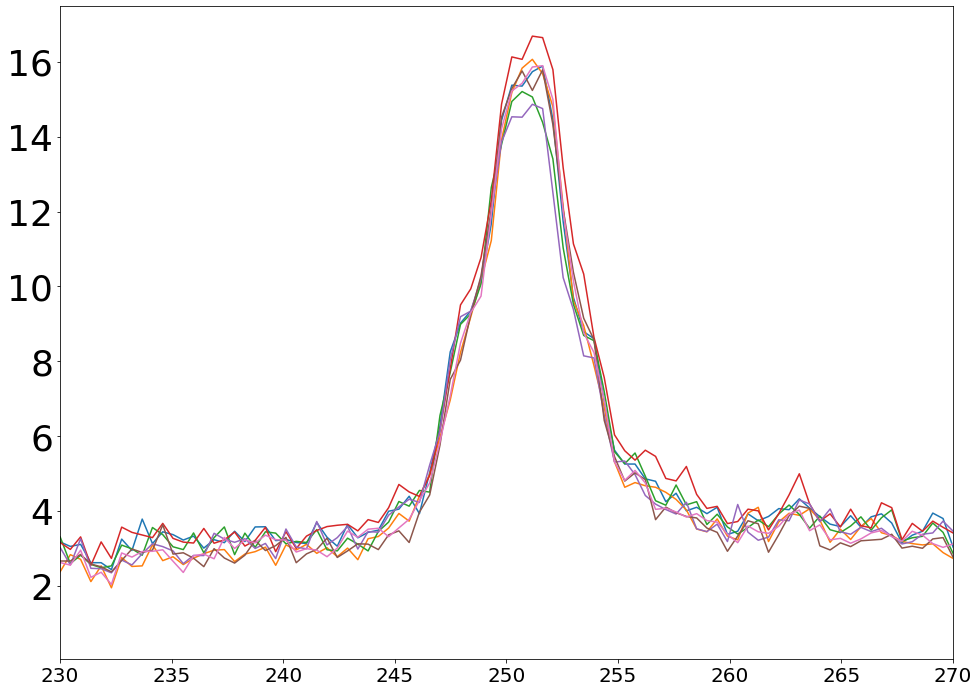

In [37]:
for i in np.arange(12333,13131,126):
    img_test3 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_%d.npy" %i).transpose()
    #img_test4 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_10381.npy").transpose()
    plt.plot(1024*0.46-np.arange(0,1024*0.46,0.46),np.mean(img_test3[600:800],axis=0))
    #plt.plot(np.mean(img_test4[600:800],axis=0))
    plt.xlim(230,270)
plt.show()

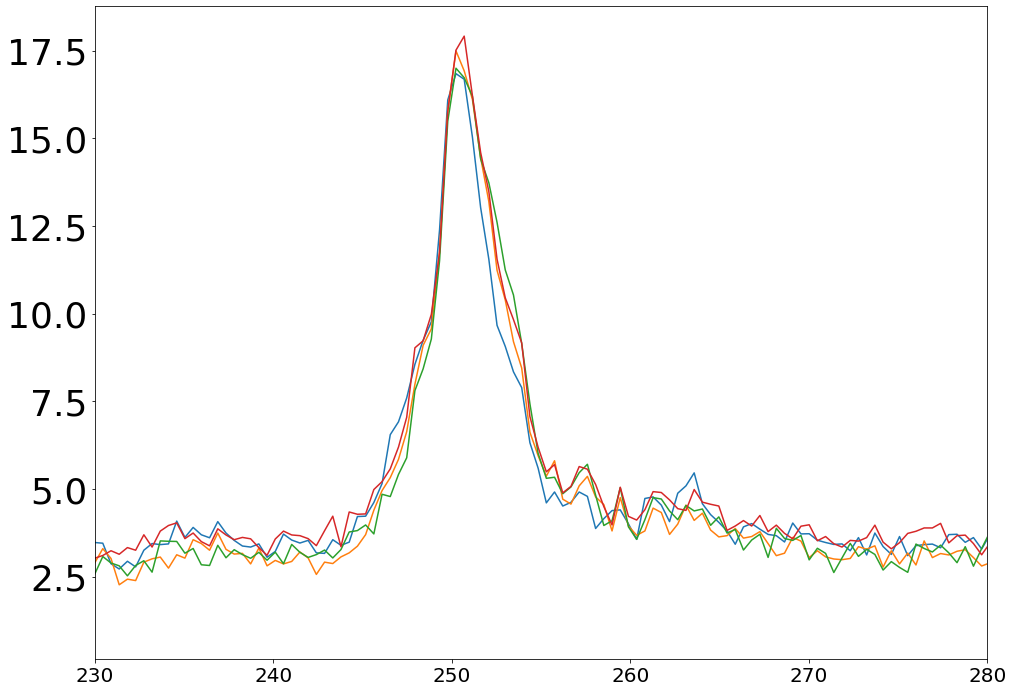

In [361]:
for i in np.arange(10,50,10):
    img_test3 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_%d.npy" %i).transpose()
    #img_test4 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3_10381.npy").transpose()
    plt.plot(1024*0.46-np.arange(0,1024*0.46,0.46),np.mean(img_test3[600:800],axis=0))
    #plt.plot(np.mean(img_test4[600:800],axis=0))
    plt.xlim(230,280)
plt.savefig("Results/Height_feedback_issues_exampl_for_good_bead.png", dpi=300, bbox_inches="tight")
plt.show()

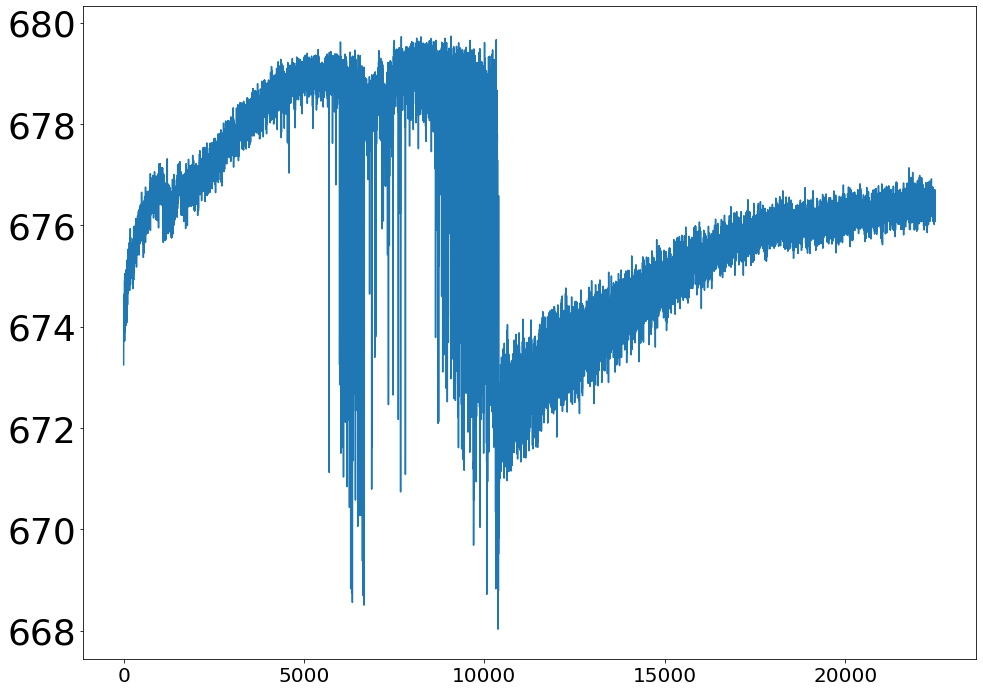

In [39]:
plt.plot(H[3])
#plt.xlim(10350,11400)

(600, 700)

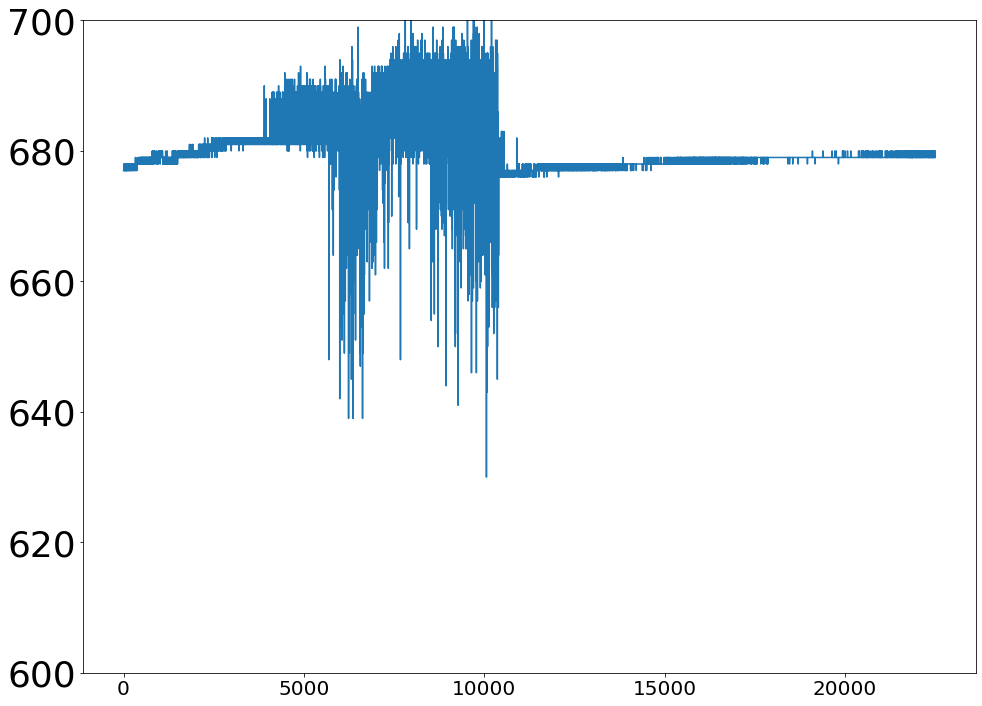

In [41]:
plt.plot(H[1])
plt.ylim(600,700)

In [35]:
new_H = 1024*0.46-np.multiply(H[0],0.46)

In [36]:
#np.savetxt("/data/new_trap/20200226/Bead1/Shaking/Shaking385/height_from_gauss.txt",new_H)

In [ ]:
img = np.load('/data/new_trap/2020026/')

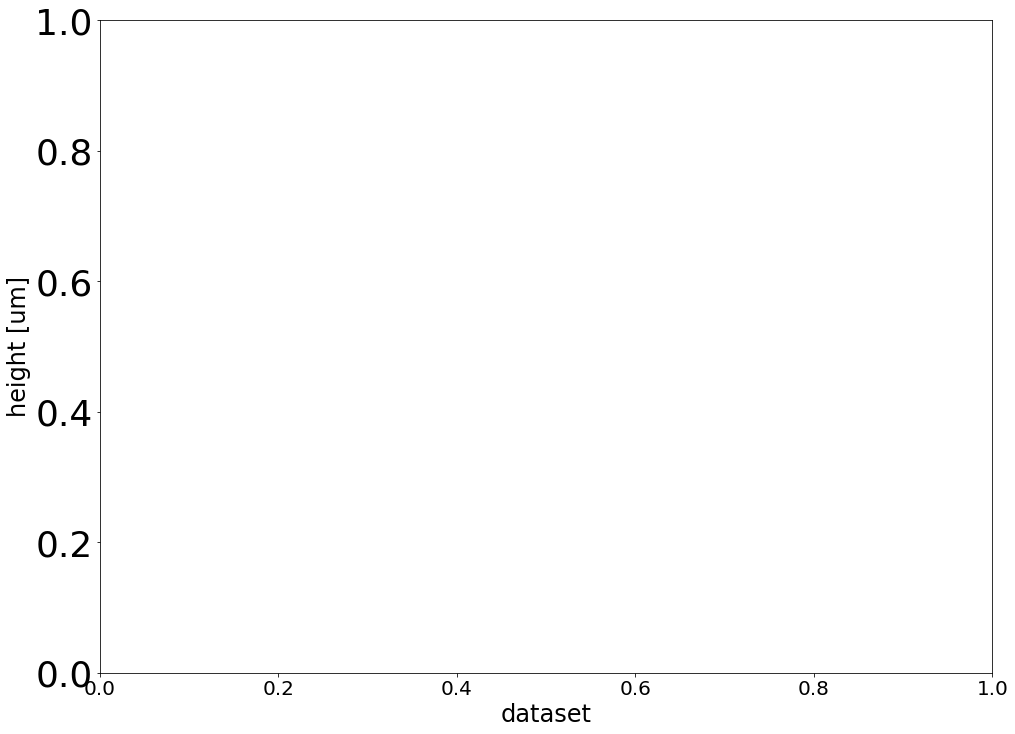

In [355]:
H0 = np.load("/data/new_trap/20200226/Bead1/Shaking/Shaking385/Pictures_0/Shaking3height_wrapped.npy", allow_pickle=True)


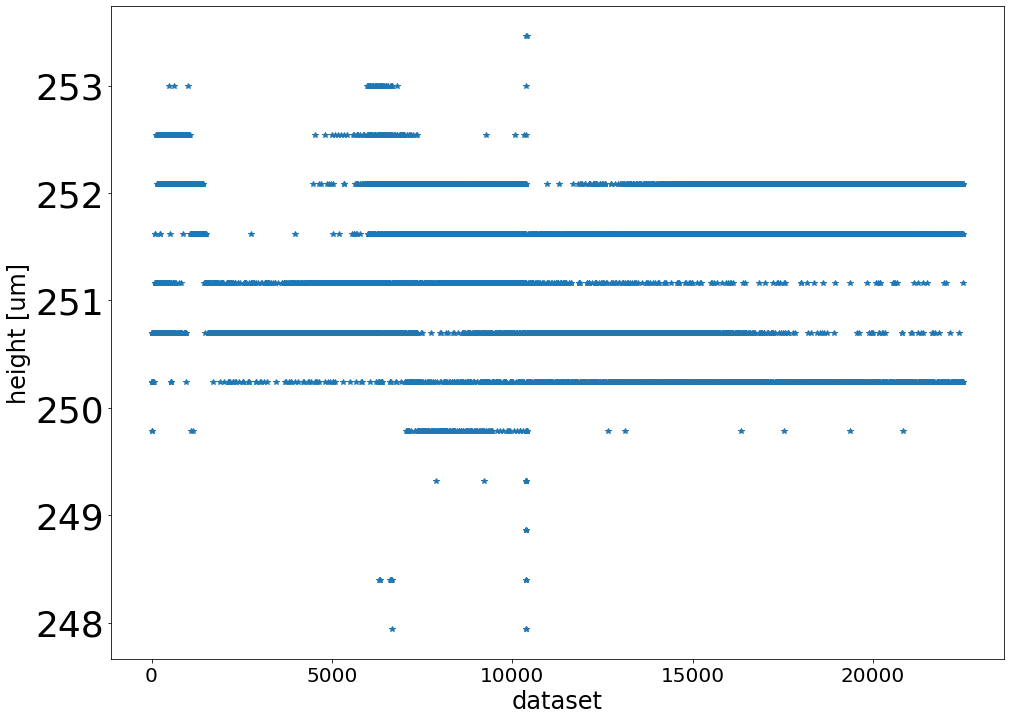

In [356]:
plt.plot(1024*0.46-np.multiply(0.46,H0[0]), linestyle="",marker="*")
plt.ylabel("height [um]")
plt.xlabel("dataset")
plt.savefig("Results/Height_feedback_issues_maxbin.png",dpi=300, bbox_inches="tight")
plt.show()

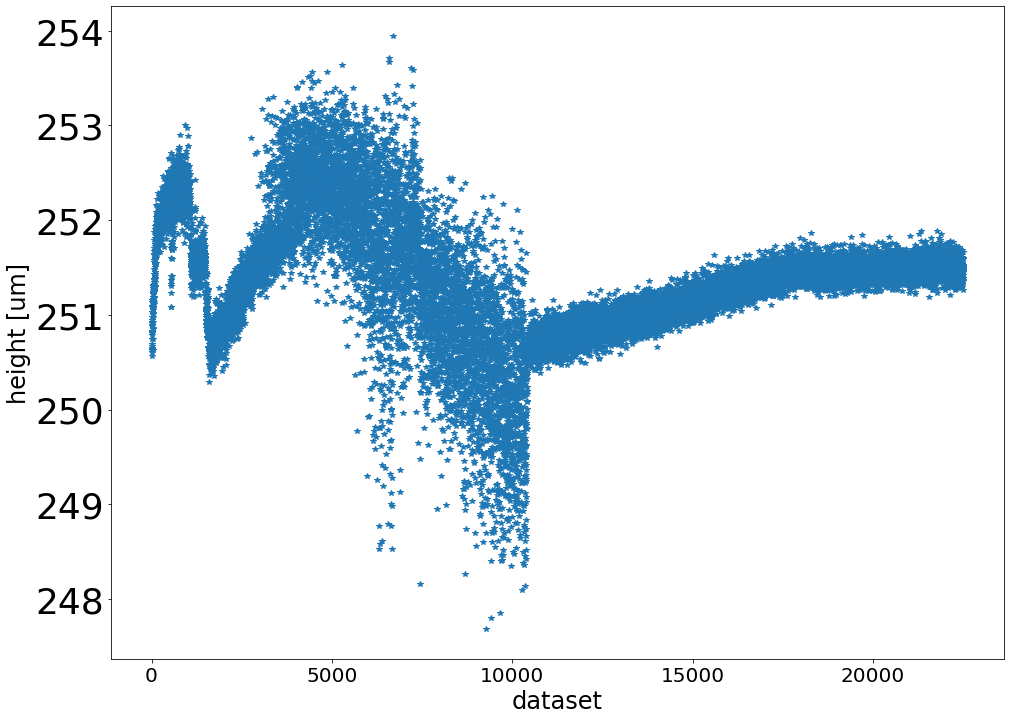

In [354]:
plt.plot(1024*0.46-np.multiply(0.46,H0[2]), linestyle="",marker="*")
plt.ylabel("height [um]")
plt.xlabel("dataset")
plt.savefig("Results/Height_feedback_issues_gaussian.png",dpi=300, bbox_inches="tight")
plt.show()

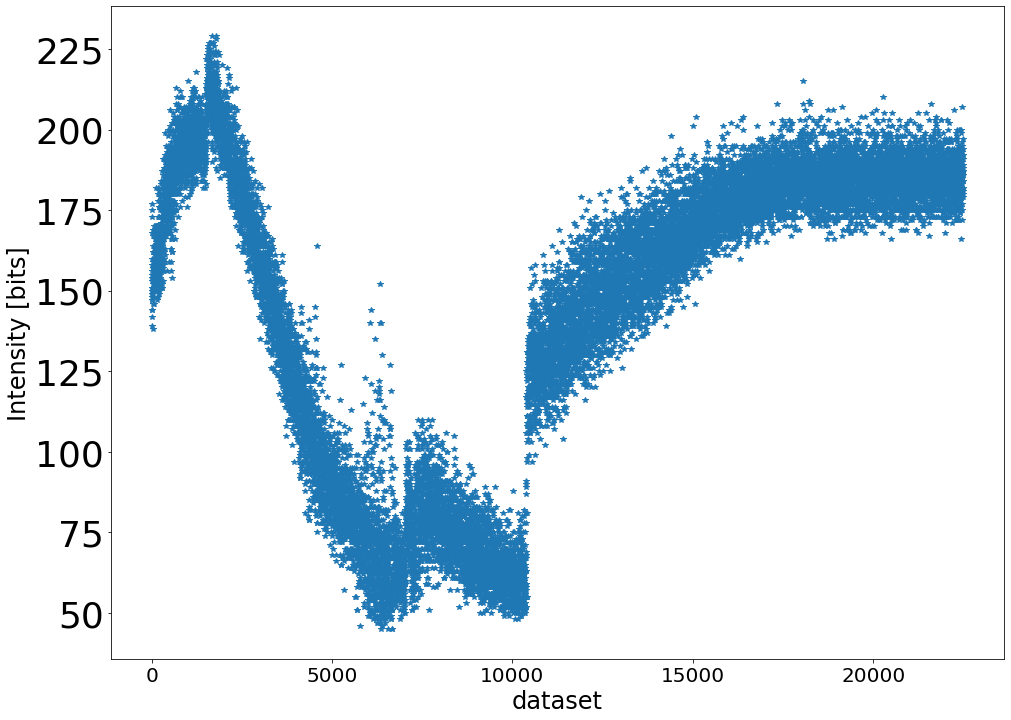

In [363]:
plt.plot(np.multiply(1,H0[5]), linestyle="",marker="*")
plt.ylabel("Intensity [bits]")
plt.xlabel("dataset")
plt.savefig("Results/Height_feedback_issues_intensity.png",dpi=300, bbox_inches="tight")
plt.show()

In [422]:
dirname = folder_basic + "/Shaking/Height/Pictures_0/"
H_dc = height_analysis_wrapper(dirname,"Height2_")






  0%|          | 0/5000 [00:00<?, ?it/s]




  0%|          | 1/5000 [00:00<13:08,  6.34it/s]




  0%|          | 2/5000 [00:00<12:15,  6.79it/s]




  0%|          | 4/5000 [00:00<11:22,  7.32it/s]




  0%|          | 5/5000 [00:00<11:55,  6.98it/s]




  0%|          | 6/5000 [00:00<11:59,  6.94it/s]




  0%|          | 7/5000 [00:00<11:22,  7.32it/s]




  0%|          | 8/5000 [00:01<10:51,  7.66it/s]




  0%|          | 9/5000 [00:01<10:59,  7.57it/s]




  0%|          | 10/5000 [00:01<11:05,  7.50it/s]




  0%|          | 11/5000 [00:01<10:27,  7.95it/s]




  0%|          | 12/5000 [00:01<10:38,  7.82it/s]




  0%|          | 13/5000 [00:01<10:13,  8.12it/s]




  0%|          | 14/5000 [00:01<10:14,  8.11it/s]




  0%|          | 15/5000 [00:01<10:19,  8.05it/s]




  0%|          | 16/5000 [00:02<10:30,  7.91it/s]




  0%|          | 17/5000 [00:02<10:05,  8.22it/s]




  0%|          | 18/5000 [00:02<09:41,  8.57it/s]




  0%|          | 19/5000 [00:02<09:52,  

  5%|▌         | 257/5000 [00:30<09:13,  8.57it/s]




  5%|▌         | 258/5000 [00:30<08:55,  8.85it/s]




  5%|▌         | 259/5000 [00:30<08:44,  9.04it/s]




  5%|▌         | 261/5000 [00:31<08:26,  9.36it/s]




  5%|▌         | 263/5000 [00:31<08:32,  9.25it/s]




  5%|▌         | 264/5000 [00:31<08:51,  8.91it/s]




  5%|▌         | 265/5000 [00:31<08:55,  8.84it/s]




  5%|▌         | 267/5000 [00:31<09:00,  8.75it/s]




  5%|▌         | 268/5000 [00:31<08:54,  8.86it/s]




  5%|▌         | 269/5000 [00:31<09:16,  8.49it/s]




  5%|▌         | 270/5000 [00:32<08:56,  8.82it/s]




  5%|▌         | 271/5000 [00:32<09:31,  8.27it/s]




  5%|▌         | 272/5000 [00:32<09:25,  8.35it/s]




  5%|▌         | 273/5000 [00:32<09:34,  8.23it/s]




  5%|▌         | 274/5000 [00:32<09:51,  7.99it/s]




  6%|▌         | 275/5000 [00:32<09:22,  8.40it/s]




  6%|▌         | 276/5000 [00:32<09:40,  8.14it/s]




  6%|▌         | 277/5000 [00:32<09:35,  8.21it/s]




  6%|▌    

 10%|█         | 518/5000 [01:00<08:33,  8.72it/s]




 10%|█         | 519/5000 [01:01<09:11,  8.13it/s]




 10%|█         | 520/5000 [01:01<09:03,  8.24it/s]




 10%|█         | 521/5000 [01:01<08:43,  8.56it/s]




 10%|█         | 522/5000 [01:01<08:50,  8.44it/s]




 10%|█         | 523/5000 [01:01<08:39,  8.62it/s]




 10%|█         | 524/5000 [01:01<08:21,  8.93it/s]




 10%|█         | 525/5000 [01:01<08:56,  8.34it/s]




 11%|█         | 526/5000 [01:01<09:08,  8.15it/s]




 11%|█         | 527/5000 [01:01<09:24,  7.92it/s]




 11%|█         | 528/5000 [01:02<08:58,  8.31it/s]




 11%|█         | 529/5000 [01:02<08:49,  8.45it/s]




 11%|█         | 530/5000 [01:02<08:48,  8.46it/s]




 11%|█         | 531/5000 [01:02<08:48,  8.46it/s]




 11%|█         | 532/5000 [01:02<08:37,  8.64it/s]




 11%|█         | 533/5000 [01:02<09:06,  8.18it/s]




 11%|█         | 534/5000 [01:02<08:49,  8.43it/s]




 11%|█         | 535/5000 [01:02<08:48,  8.45it/s]




 11%|█    

 16%|█▌        | 775/5000 [01:31<08:08,  8.65it/s]




 16%|█▌        | 776/5000 [01:31<08:12,  8.59it/s]




 16%|█▌        | 777/5000 [01:31<08:09,  8.63it/s]




 16%|█▌        | 778/5000 [01:31<08:42,  8.09it/s]




 16%|█▌        | 779/5000 [01:31<08:34,  8.20it/s]




 16%|█▌        | 781/5000 [01:32<08:17,  8.48it/s]




 16%|█▌        | 782/5000 [01:32<08:08,  8.63it/s]




 16%|█▌        | 783/5000 [01:32<07:53,  8.91it/s]




 16%|█▌        | 784/5000 [01:32<08:00,  8.77it/s]




 16%|█▌        | 785/5000 [01:32<08:40,  8.09it/s]




 16%|█▌        | 786/5000 [01:32<08:19,  8.43it/s]




 16%|█▌        | 787/5000 [01:32<08:14,  8.52it/s]




 16%|█▌        | 789/5000 [01:33<08:03,  8.71it/s]




 16%|█▌        | 790/5000 [01:33<08:16,  8.47it/s]




 16%|█▌        | 791/5000 [01:33<08:11,  8.56it/s]




 16%|█▌        | 792/5000 [01:33<08:29,  8.25it/s]




 16%|█▌        | 793/5000 [01:33<08:21,  8.38it/s]




 16%|█▌        | 794/5000 [01:33<08:34,  8.17it/s]




 16%|█▌   

 21%|██        | 1037/5000 [02:01<08:18,  7.95it/s]




 21%|██        | 1038/5000 [02:01<08:18,  7.95it/s]




 21%|██        | 1039/5000 [02:01<07:59,  8.26it/s]




 21%|██        | 1040/5000 [02:02<07:39,  8.63it/s]




 21%|██        | 1041/5000 [02:02<07:41,  8.58it/s]




 21%|██        | 1042/5000 [02:02<07:33,  8.73it/s]




 21%|██        | 1043/5000 [02:02<08:20,  7.90it/s]




 21%|██        | 1044/5000 [02:02<08:07,  8.12it/s]




 21%|██        | 1045/5000 [02:02<08:04,  8.16it/s]




 21%|██        | 1046/5000 [02:02<07:52,  8.36it/s]




 21%|██        | 1047/5000 [02:02<07:56,  8.29it/s]




 21%|██        | 1048/5000 [02:03<07:47,  8.46it/s]




 21%|██        | 1049/5000 [02:03<07:27,  8.84it/s]




 21%|██        | 1051/5000 [02:03<07:29,  8.78it/s]




 21%|██        | 1052/5000 [02:03<07:50,  8.39it/s]




 21%|██        | 1054/5000 [02:03<07:38,  8.61it/s]




 21%|██        | 1055/5000 [02:03<08:04,  8.14it/s]




 21%|██        | 1056/5000 [02:03<07:55,  8.30it

 26%|██▌       | 1293/5000 [02:32<07:44,  7.97it/s]




 26%|██▌       | 1294/5000 [02:32<07:47,  7.92it/s]




 26%|██▌       | 1295/5000 [02:32<07:30,  8.23it/s]




 26%|██▌       | 1296/5000 [02:32<07:18,  8.44it/s]




 26%|██▌       | 1297/5000 [02:32<07:23,  8.36it/s]




 26%|██▌       | 1298/5000 [02:32<07:22,  8.38it/s]




 26%|██▌       | 1299/5000 [02:32<07:18,  8.44it/s]




 26%|██▌       | 1300/5000 [02:33<07:03,  8.74it/s]




 26%|██▌       | 1302/5000 [02:33<06:39,  9.25it/s]




 26%|██▌       | 1303/5000 [02:33<06:50,  9.00it/s]




 26%|██▌       | 1304/5000 [02:33<06:54,  8.92it/s]




 26%|██▌       | 1306/5000 [02:33<06:47,  9.06it/s]




 26%|██▌       | 1307/5000 [02:33<06:57,  8.85it/s]




 26%|██▌       | 1308/5000 [02:33<06:59,  8.79it/s]




 26%|██▌       | 1309/5000 [02:34<06:54,  8.90it/s]




 26%|██▌       | 1311/5000 [02:34<07:05,  8.68it/s]




 26%|██▌       | 1312/5000 [02:34<07:30,  8.19it/s]




 26%|██▋       | 1314/5000 [02:34<07:17,  8.43it

 31%|███       | 1551/5000 [03:02<08:05,  7.10it/s]




 31%|███       | 1552/5000 [03:02<07:46,  7.40it/s]




 31%|███       | 1553/5000 [03:02<07:28,  7.69it/s]




 31%|███       | 1554/5000 [03:02<07:32,  7.62it/s]




 31%|███       | 1555/5000 [03:02<07:29,  7.67it/s]




 31%|███       | 1556/5000 [03:02<07:31,  7.62it/s]




 31%|███       | 1557/5000 [03:03<07:23,  7.76it/s]




 31%|███       | 1558/5000 [03:03<07:09,  8.01it/s]




 31%|███       | 1559/5000 [03:03<07:05,  8.08it/s]




 31%|███       | 1560/5000 [03:03<07:11,  7.97it/s]




 31%|███       | 1562/5000 [03:03<06:45,  8.48it/s]




 31%|███▏      | 1563/5000 [03:03<06:42,  8.53it/s]




 31%|███▏      | 1564/5000 [03:03<06:39,  8.61it/s]




 31%|███▏      | 1565/5000 [03:03<07:04,  8.10it/s]




 31%|███▏      | 1566/5000 [03:04<06:55,  8.26it/s]




 31%|███▏      | 1567/5000 [03:04<07:50,  7.29it/s]




 31%|███▏      | 1569/5000 [03:04<07:29,  7.64it/s]




 31%|███▏      | 1570/5000 [03:04<07:19,  7.80it

 36%|███▌      | 1801/5000 [03:32<06:17,  8.47it/s]




 36%|███▌      | 1802/5000 [03:32<06:19,  8.44it/s]




 36%|███▌      | 1803/5000 [03:32<06:10,  8.64it/s]




 36%|███▌      | 1804/5000 [03:32<06:20,  8.40it/s]




 36%|███▌      | 1805/5000 [03:33<06:31,  8.16it/s]




 36%|███▌      | 1807/5000 [03:33<06:12,  8.57it/s]




 36%|███▌      | 1808/5000 [03:33<05:56,  8.94it/s]




 36%|███▌      | 1809/5000 [03:33<06:01,  8.83it/s]




 36%|███▌      | 1810/5000 [03:33<06:02,  8.80it/s]




 36%|███▌      | 1811/5000 [03:33<06:03,  8.77it/s]




 36%|███▌      | 1812/5000 [03:33<06:12,  8.57it/s]




 36%|███▋      | 1813/5000 [03:33<06:04,  8.73it/s]




 36%|███▋      | 1814/5000 [03:34<06:08,  8.64it/s]




 36%|███▋      | 1815/5000 [03:34<06:09,  8.62it/s]




 36%|███▋      | 1817/5000 [03:34<05:35,  9.50it/s]




 36%|███▋      | 1818/5000 [03:34<05:32,  9.57it/s]




 36%|███▋      | 1819/5000 [03:34<05:59,  8.84it/s]




 36%|███▋      | 1820/5000 [03:34<05:48,  9.13it

 41%|████▏     | 2066/5000 [04:03<05:42,  8.57it/s]




 41%|████▏     | 2067/5000 [04:03<05:43,  8.54it/s]




 41%|████▏     | 2068/5000 [04:03<05:52,  8.31it/s]




 41%|████▏     | 2069/5000 [04:03<05:51,  8.34it/s]




 41%|████▏     | 2070/5000 [04:03<05:58,  8.16it/s]




 41%|████▏     | 2071/5000 [04:03<05:50,  8.36it/s]




 41%|████▏     | 2072/5000 [04:03<06:48,  7.18it/s]




 41%|████▏     | 2073/5000 [04:04<06:58,  7.00it/s]




 42%|████▏     | 2075/5000 [04:04<06:25,  7.59it/s]




 42%|████▏     | 2076/5000 [04:04<06:19,  7.70it/s]




 42%|████▏     | 2078/5000 [04:04<06:03,  8.04it/s]




 42%|████▏     | 2079/5000 [04:04<05:55,  8.22it/s]




 42%|████▏     | 2080/5000 [04:04<05:53,  8.27it/s]




 42%|████▏     | 2081/5000 [04:05<05:49,  8.34it/s]




 42%|████▏     | 2082/5000 [04:05<05:50,  8.33it/s]




 42%|████▏     | 2083/5000 [04:05<05:39,  8.59it/s]




 42%|████▏     | 2085/5000 [04:05<05:21,  9.07it/s]




 42%|████▏     | 2086/5000 [04:05<05:29,  8.85it

 46%|████▋     | 2314/5000 [04:33<04:48,  9.30it/s]




 46%|████▋     | 2316/5000 [04:33<04:37,  9.69it/s]




 46%|████▋     | 2317/5000 [04:33<05:05,  8.77it/s]




 46%|████▋     | 2318/5000 [04:33<05:15,  8.49it/s]




 46%|████▋     | 2319/5000 [04:33<05:02,  8.85it/s]




 46%|████▋     | 2320/5000 [04:33<04:58,  8.98it/s]




 46%|████▋     | 2322/5000 [04:33<04:49,  9.25it/s]




 46%|████▋     | 2323/5000 [04:34<04:46,  9.35it/s]




 46%|████▋     | 2324/5000 [04:34<04:54,  9.08it/s]




 47%|████▋     | 2326/5000 [04:34<04:47,  9.31it/s]




 47%|████▋     | 2327/5000 [04:34<04:42,  9.46it/s]




 47%|████▋     | 2328/5000 [04:34<04:55,  9.03it/s]




 47%|████▋     | 2329/5000 [04:34<05:11,  8.57it/s]




 47%|████▋     | 2330/5000 [04:34<05:26,  8.19it/s]




 47%|████▋     | 2332/5000 [04:35<05:04,  8.75it/s]




 47%|████▋     | 2333/5000 [04:35<04:59,  8.89it/s]




 47%|████▋     | 2334/5000 [04:35<05:24,  8.22it/s]




 47%|████▋     | 2335/5000 [04:35<05:17,  8.39it

 52%|█████▏    | 2575/5000 [05:03<04:45,  8.50it/s]




 52%|█████▏    | 2576/5000 [05:03<04:38,  8.69it/s]




 52%|█████▏    | 2577/5000 [05:03<05:09,  7.84it/s]




 52%|█████▏    | 2578/5000 [05:03<05:03,  7.99it/s]




 52%|█████▏    | 2579/5000 [05:03<05:14,  7.71it/s]




 52%|█████▏    | 2580/5000 [05:04<05:07,  7.87it/s]




 52%|█████▏    | 2581/5000 [05:04<05:07,  7.86it/s]




 52%|█████▏    | 2582/5000 [05:04<05:11,  7.76it/s]




 52%|█████▏    | 2583/5000 [05:04<05:03,  7.95it/s]




 52%|█████▏    | 2584/5000 [05:04<04:51,  8.29it/s]




 52%|█████▏    | 2585/5000 [05:04<05:14,  7.67it/s]




 52%|█████▏    | 2586/5000 [05:04<05:40,  7.10it/s]




 52%|█████▏    | 2587/5000 [05:04<05:32,  7.25it/s]




 52%|█████▏    | 2588/5000 [05:05<05:34,  7.22it/s]




 52%|█████▏    | 2589/5000 [05:05<05:31,  7.27it/s]




 52%|█████▏    | 2590/5000 [05:05<05:11,  7.73it/s]




 52%|█████▏    | 2591/5000 [05:05<05:11,  7.75it/s]




 52%|█████▏    | 2592/5000 [05:05<05:27,  7.36it

 56%|█████▋    | 2818/5000 [05:32<04:24,  8.26it/s]




 56%|█████▋    | 2820/5000 [05:32<04:06,  8.84it/s]




 56%|█████▋    | 2822/5000 [05:32<04:08,  8.75it/s]




 56%|█████▋    | 2823/5000 [05:32<04:07,  8.79it/s]




 56%|█████▋    | 2824/5000 [05:32<04:03,  8.92it/s]




 56%|█████▋    | 2825/5000 [05:33<04:05,  8.84it/s]




 57%|█████▋    | 2826/5000 [05:33<04:08,  8.76it/s]




 57%|█████▋    | 2827/5000 [05:33<04:02,  8.96it/s]




 57%|█████▋    | 2828/5000 [05:33<03:55,  9.22it/s]




 57%|█████▋    | 2829/5000 [05:33<04:09,  8.71it/s]




 57%|█████▋    | 2830/5000 [05:33<04:06,  8.79it/s]




 57%|█████▋    | 2831/5000 [05:33<04:02,  8.95it/s]




 57%|█████▋    | 2832/5000 [05:33<04:00,  9.00it/s]




 57%|█████▋    | 2833/5000 [05:33<04:00,  9.00it/s]




 57%|█████▋    | 2834/5000 [05:34<03:54,  9.22it/s]




 57%|█████▋    | 2835/5000 [05:34<03:57,  9.10it/s]




 57%|█████▋    | 2836/5000 [05:34<04:04,  8.85it/s]




 57%|█████▋    | 2837/5000 [05:34<04:10,  8.64it

 62%|██████▏   | 3079/5000 [06:02<03:51,  8.29it/s]




 62%|██████▏   | 3081/5000 [06:02<03:37,  8.82it/s]




 62%|██████▏   | 3082/5000 [06:02<03:44,  8.53it/s]




 62%|██████▏   | 3083/5000 [06:02<03:40,  8.70it/s]




 62%|██████▏   | 3084/5000 [06:02<03:41,  8.66it/s]




 62%|██████▏   | 3085/5000 [06:02<03:48,  8.39it/s]




 62%|██████▏   | 3086/5000 [06:03<03:56,  8.09it/s]




 62%|██████▏   | 3087/5000 [06:03<03:57,  8.05it/s]




 62%|██████▏   | 3088/5000 [06:03<03:48,  8.36it/s]




 62%|██████▏   | 3089/5000 [06:03<03:44,  8.51it/s]




 62%|██████▏   | 3090/5000 [06:03<03:41,  8.63it/s]




 62%|██████▏   | 3091/5000 [06:03<03:49,  8.31it/s]




 62%|██████▏   | 3092/5000 [06:03<03:48,  8.34it/s]




 62%|██████▏   | 3093/5000 [06:03<03:40,  8.65it/s]




 62%|██████▏   | 3094/5000 [06:03<04:01,  7.90it/s]




 62%|██████▏   | 3096/5000 [06:04<03:45,  8.44it/s]




 62%|██████▏   | 3097/5000 [06:04<03:37,  8.76it/s]




 62%|██████▏   | 3098/5000 [06:04<03:42,  8.55it

 67%|██████▋   | 3337/5000 [06:32<02:58,  9.29it/s]




 67%|██████▋   | 3338/5000 [06:32<02:57,  9.34it/s]




 67%|██████▋   | 3339/5000 [06:32<03:11,  8.68it/s]




 67%|██████▋   | 3340/5000 [06:32<03:11,  8.66it/s]




 67%|██████▋   | 3341/5000 [06:32<03:22,  8.20it/s]




 67%|██████▋   | 3342/5000 [06:32<03:16,  8.44it/s]




 67%|██████▋   | 3343/5000 [06:33<03:07,  8.84it/s]




 67%|██████▋   | 3344/5000 [06:33<03:10,  8.68it/s]




 67%|██████▋   | 3345/5000 [06:33<03:14,  8.49it/s]




 67%|██████▋   | 3346/5000 [06:33<03:14,  8.51it/s]




 67%|██████▋   | 3347/5000 [06:33<03:16,  8.41it/s]




 67%|██████▋   | 3349/5000 [06:33<03:12,  8.58it/s]




 67%|██████▋   | 3350/5000 [06:33<03:09,  8.71it/s]




 67%|██████▋   | 3352/5000 [06:34<03:05,  8.87it/s]




 67%|██████▋   | 3353/5000 [06:34<03:01,  9.07it/s]




 67%|██████▋   | 3354/5000 [06:34<02:59,  9.19it/s]




 67%|██████▋   | 3355/5000 [06:34<03:00,  9.14it/s]




 67%|██████▋   | 3356/5000 [06:34<02:55,  9.35it

 72%|███████▏  | 3607/5000 [07:03<02:38,  8.77it/s]




 72%|███████▏  | 3608/5000 [07:03<02:43,  8.53it/s]




 72%|███████▏  | 3610/5000 [07:04<02:36,  8.91it/s]




 72%|███████▏  | 3611/5000 [07:04<02:46,  8.35it/s]




 72%|███████▏  | 3612/5000 [07:04<03:03,  7.55it/s]




 72%|███████▏  | 3613/5000 [07:04<02:52,  8.06it/s]




 72%|███████▏  | 3614/5000 [07:04<02:58,  7.74it/s]




 72%|███████▏  | 3615/5000 [07:04<03:00,  7.66it/s]




 72%|███████▏  | 3616/5000 [07:04<02:57,  7.81it/s]




 72%|███████▏  | 3618/5000 [07:05<02:54,  7.91it/s]




 72%|███████▏  | 3619/5000 [07:05<02:49,  8.15it/s]




 72%|███████▏  | 3620/5000 [07:05<02:43,  8.45it/s]




 72%|███████▏  | 3621/5000 [07:05<02:51,  8.03it/s]




 72%|███████▏  | 3622/5000 [07:05<02:55,  7.86it/s]




 72%|███████▏  | 3623/5000 [07:05<02:47,  8.23it/s]




 72%|███████▏  | 3624/5000 [07:05<02:48,  8.19it/s]




 72%|███████▎  | 3625/5000 [07:05<02:54,  7.90it/s]




 73%|███████▎  | 3626/5000 [07:06<02:55,  7.85it

 77%|███████▋  | 3855/5000 [07:33<02:10,  8.74it/s]




 77%|███████▋  | 3856/5000 [07:33<02:13,  8.57it/s]




 77%|███████▋  | 3858/5000 [07:33<02:11,  8.69it/s]




 77%|███████▋  | 3860/5000 [07:34<02:07,  8.95it/s]




 77%|███████▋  | 3861/5000 [07:34<02:08,  8.85it/s]




 77%|███████▋  | 3863/5000 [07:34<02:09,  8.75it/s]




 77%|███████▋  | 3864/5000 [07:34<02:13,  8.49it/s]




 77%|███████▋  | 3865/5000 [07:34<02:11,  8.61it/s]




 77%|███████▋  | 3867/5000 [07:34<02:11,  8.63it/s]




 77%|███████▋  | 3868/5000 [07:35<02:06,  8.97it/s]




 77%|███████▋  | 3870/5000 [07:35<02:00,  9.40it/s]




 77%|███████▋  | 3871/5000 [07:35<01:58,  9.55it/s]




 77%|███████▋  | 3872/5000 [07:35<01:58,  9.55it/s]




 77%|███████▋  | 3873/5000 [07:35<02:02,  9.18it/s]




 77%|███████▋  | 3874/5000 [07:35<01:59,  9.40it/s]




 78%|███████▊  | 3876/5000 [07:35<02:02,  9.19it/s]




 78%|███████▊  | 3877/5000 [07:35<02:06,  8.87it/s]




 78%|███████▊  | 3878/5000 [07:36<02:27,  7.60it

 82%|████████▎ | 4125/5000 [08:04<01:44,  8.38it/s]




 83%|████████▎ | 4126/5000 [08:05<01:41,  8.64it/s]




 83%|████████▎ | 4127/5000 [08:05<01:39,  8.76it/s]




 83%|████████▎ | 4128/5000 [08:05<01:43,  8.44it/s]




 83%|████████▎ | 4129/5000 [08:05<01:49,  7.97it/s]




 83%|████████▎ | 4130/5000 [08:05<01:52,  7.74it/s]




 83%|████████▎ | 4131/5000 [08:05<01:51,  7.80it/s]




 83%|████████▎ | 4132/5000 [08:05<01:53,  7.67it/s]




 83%|████████▎ | 4133/5000 [08:06<01:50,  7.82it/s]




 83%|████████▎ | 4134/5000 [08:06<01:47,  8.03it/s]




 83%|████████▎ | 4135/5000 [08:06<01:50,  7.81it/s]




 83%|████████▎ | 4136/5000 [08:06<01:54,  7.57it/s]




 83%|████████▎ | 4137/5000 [08:06<01:51,  7.77it/s]




 83%|████████▎ | 4138/5000 [08:06<01:50,  7.82it/s]




 83%|████████▎ | 4139/5000 [08:06<01:49,  7.83it/s]




 83%|████████▎ | 4140/5000 [08:06<01:54,  7.50it/s]




 83%|████████▎ | 4141/5000 [08:07<01:49,  7.82it/s]




 83%|████████▎ | 4142/5000 [08:07<01:49,  7.82it

 87%|████████▋ | 4374/5000 [08:34<01:26,  7.26it/s]




 88%|████████▊ | 4375/5000 [08:35<01:21,  7.63it/s]




 88%|████████▊ | 4376/5000 [08:35<01:17,  8.08it/s]




 88%|████████▊ | 4377/5000 [08:35<01:14,  8.41it/s]




 88%|████████▊ | 4378/5000 [08:35<01:12,  8.61it/s]




 88%|████████▊ | 4379/5000 [08:35<01:11,  8.73it/s]




 88%|████████▊ | 4380/5000 [08:35<01:09,  8.91it/s]




 88%|████████▊ | 4381/5000 [08:35<01:13,  8.44it/s]




 88%|████████▊ | 4382/5000 [08:35<01:11,  8.61it/s]




 88%|████████▊ | 4383/5000 [08:35<01:11,  8.64it/s]




 88%|████████▊ | 4384/5000 [08:36<01:10,  8.68it/s]




 88%|████████▊ | 4385/5000 [08:36<01:22,  7.49it/s]




 88%|████████▊ | 4386/5000 [08:36<01:22,  7.43it/s]




 88%|████████▊ | 4387/5000 [08:36<01:17,  7.86it/s]




 88%|████████▊ | 4388/5000 [08:36<01:15,  8.11it/s]




 88%|████████▊ | 4389/5000 [08:36<01:19,  7.71it/s]




 88%|████████▊ | 4390/5000 [08:36<01:15,  8.08it/s]




 88%|████████▊ | 4391/5000 [08:36<01:12,  8.38it

 93%|█████████▎| 4632/5000 [09:29<00:47,  7.75it/s]




 93%|█████████▎| 4633/5000 [09:29<00:45,  8.07it/s]




 93%|█████████▎| 4634/5000 [09:29<00:48,  7.60it/s]




 93%|█████████▎| 4635/5000 [09:29<00:47,  7.76it/s]




 93%|█████████▎| 4636/5000 [09:30<00:44,  8.10it/s]




 93%|█████████▎| 4637/5000 [09:30<00:45,  7.95it/s]




 93%|█████████▎| 4638/5000 [09:30<00:44,  8.17it/s]




 93%|█████████▎| 4639/5000 [09:30<00:44,  8.12it/s]




 93%|█████████▎| 4640/5000 [09:30<00:42,  8.40it/s]




 93%|█████████▎| 4641/5000 [09:30<00:44,  8.03it/s]




 93%|█████████▎| 4642/5000 [09:30<00:42,  8.40it/s]




 93%|█████████▎| 4643/5000 [09:30<00:42,  8.46it/s]




 93%|█████████▎| 4644/5000 [09:31<00:42,  8.37it/s]




 93%|█████████▎| 4645/5000 [09:31<00:40,  8.75it/s]




 93%|█████████▎| 4646/5000 [09:31<00:41,  8.50it/s]




 93%|█████████▎| 4647/5000 [09:31<00:41,  8.52it/s]




 93%|█████████▎| 4648/5000 [09:31<00:40,  8.73it/s]




 93%|█████████▎| 4649/5000 [09:31<00:39,  8.85it

 97%|█████████▋| 4872/5000 [09:59<00:18,  6.99it/s]




 97%|█████████▋| 4873/5000 [10:00<00:19,  6.40it/s]




 97%|█████████▋| 4874/5000 [10:00<00:20,  6.27it/s]




 98%|█████████▊| 4875/5000 [10:00<00:19,  6.32it/s]




 98%|█████████▊| 4876/5000 [10:00<00:19,  6.47it/s]




 98%|█████████▊| 4877/5000 [10:00<00:19,  6.35it/s]




 98%|█████████▊| 4878/5000 [10:00<00:17,  6.93it/s]




 98%|█████████▊| 4879/5000 [10:00<00:16,  7.30it/s]




 98%|█████████▊| 4880/5000 [10:01<00:16,  7.23it/s]




 98%|█████████▊| 4881/5000 [10:01<00:16,  7.29it/s]




 98%|█████████▊| 4882/5000 [10:01<00:15,  7.40it/s]




 98%|█████████▊| 4883/5000 [10:01<00:15,  7.59it/s]




 98%|█████████▊| 4884/5000 [10:01<00:15,  7.51it/s]




 98%|█████████▊| 4885/5000 [10:01<00:15,  7.23it/s]




 98%|█████████▊| 4886/5000 [10:01<00:17,  6.48it/s]




 98%|█████████▊| 4887/5000 [10:02<00:17,  6.59it/s]




 98%|█████████▊| 4888/5000 [10:02<00:16,  6.74it/s]




 98%|█████████▊| 4889/5000 [10:02<00:16,  6.77it

Time passed 616


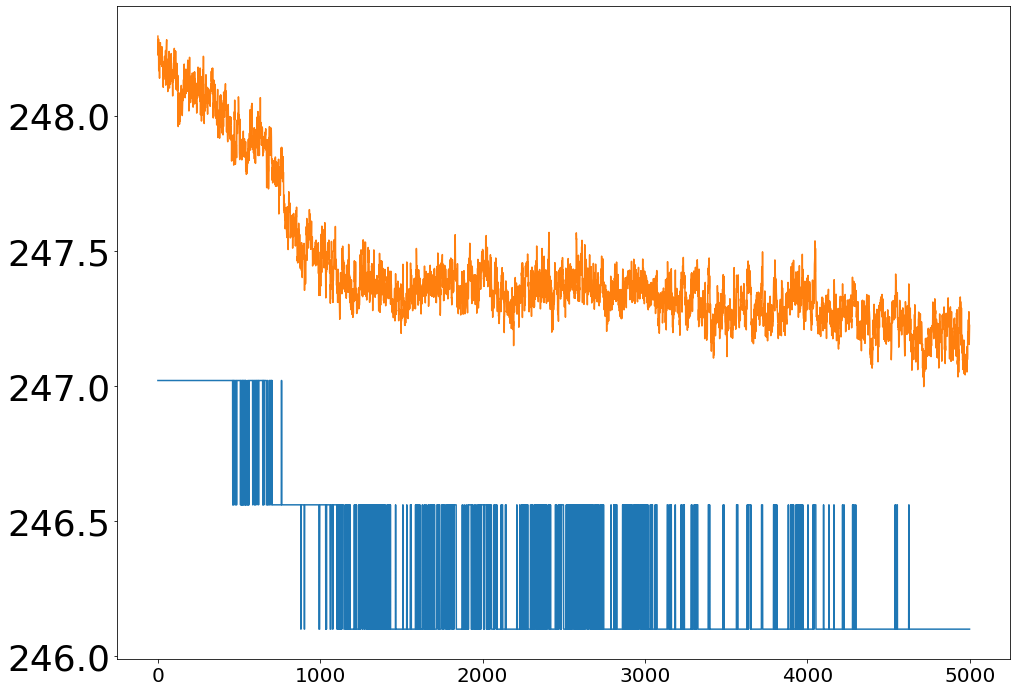

In [426]:
plt.plot(1024*0.46-np.multiply(0.46,H_dc[-1]))
plt.plot(1024*0.46-np.multiply(0.46,H_dc[2]))